In [3]:
import json
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from icecream import ic
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

import sys

print(str(Path(os.getcwd()).parent))
sys.path.append(str(Path(os.getcwd()).parent))

from src import GRID_SIZE, SCREEN_SIZE, CELL_SIZE
from src.utils.game import Game

/Users/roman/git/personal/goban-watcher/src


ModuleNotFoundError: No module named 'src'

In [2]:
root_path = Path(os.getcwd()).parent
img_path = root_path.joinpath("images/selected_sgf")
sgf_path = root_path.joinpath("sgf/selected_sgf")

In [53]:
CLASSES = (0, 1, 2)

TRAIN_PERCENTAGE = 0.7
BATCH_SIZE = 32
LEARNING_RATE = 0.01
EPOCHS = 5

In [4]:
with open("corners.json", "r") as f:
    data = json.load(f)

In [5]:
games = {}
for i in data.keys():
    game = Game()
    game.add_sgf(sgf_path.joinpath(f"{i}.sgf"))
    games[i] = game

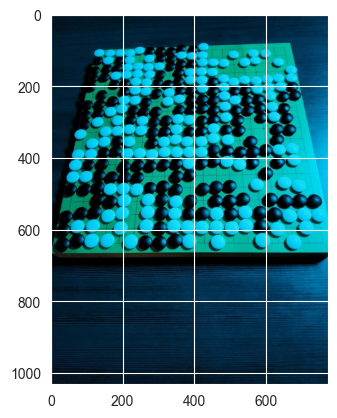

In [6]:
img = cv2.imread(str(img_path.joinpath("1", "1_jwerth_cyan_2.jpg")))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [7]:
def transform_image(img: np.ndarray, corners: list[list[float]]) -> np.ndarray:
    matrix = cv2.getPerspectiveTransform(
        np.float32(
            [[int(c[0] * img.shape[1]), int(c[1] * img.shape[0])] for c in corners]
        ),
        np.float32(
            [
                [0, 0],
                [SCREEN_SIZE, 0],
                [SCREEN_SIZE, SCREEN_SIZE],
                [0, SCREEN_SIZE],
            ]
        ),
    )
    return cv2.warpPerspective(img, matrix, (SCREEN_SIZE, SCREEN_SIZE))


def extract_cells(frame) -> list:
    transformed_cell_size = SCREEN_SIZE // GRID_SIZE
    half_cell_size = transformed_cell_size // 2

    return [
        frame[
            max(0, y * transformed_cell_size - half_cell_size) : min(
                frame.shape[0],
                (y + 1) * transformed_cell_size + half_cell_size,
            ),
            max(0, x * transformed_cell_size - half_cell_size) : min(
                frame.shape[1],
                (x + 1) * transformed_cell_size + half_cell_size,
            ),
        ]
        for y in range(GRID_SIZE)
        for x in range(GRID_SIZE)
    ]


In [23]:
labels = []
for key, images in tqdm(data.items()):
    for filename, corners in images.items():
        image = cv2.imread(str(img_path.joinpath(key, filename)))
        transformed_img = transform_image(image, corners)

        cell_images = extract_cells(transformed_img)

        # (class, image)
        labels += [
            (games[key].board[y][x].value, cell_images[y][x])
            for x in range(GRID_SIZE)
            for y in range(GRID_SIZE)
        ]


100%|██████████| 11/11 [00:00<00:00, 12.93it/s]


2


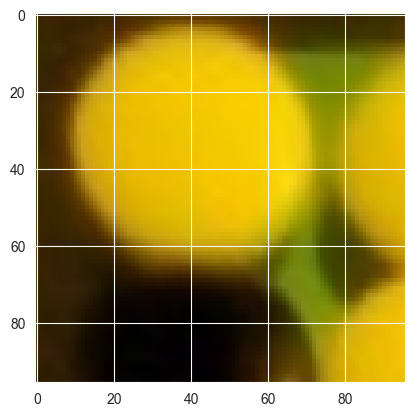

In [26]:
print(labels[0][0])
plt.imshow(labels[0][1])
plt.show()

In [27]:
df_labels = pd.DataFrame(labels)
df_labels[0].value_counts()

0
0    10433
1     8197
2     8084
Name: count, dtype: int64

In [29]:
# Randomize
df_labels = df_labels.sample(frac=1, random_state=10).reset_index(drop=True)
df_labels[0].value_counts()

0
0    10433
1     8197
2     8084
Name: count, dtype: int64

### Undersample

In [30]:
column_name = df_labels.columns[0]

# Count the number of samples in each category
min_count = df_labels[column_name].value_counts().min()

# Create a list to hold the undersampled DataFrame
undersampled_df = pd.DataFrame()

# Loop through each category and sample
for label in df_labels[column_name].unique():
    undersampled_df = pd.concat(
        [
            undersampled_df,
            df_labels[df_labels[column_name] == label].sample(
                min_count, random_state=42
            ),
        ]
    )

df_labels = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
df_labels[0].value_counts()

0
2    8084
1    8084
0    8084
Name: count, dtype: int64

In [31]:
total_labels = df_labels.shape[0]
ic(total_labels)
amount_train_labels = int(total_labels * TRAIN_PERCENTAGE)

train_labels, test_labels = (
    df_labels[:amount_train_labels],
    df_labels[amount_train_labels:],
)
ic(len(train_labels))
ic(len(test_labels))

ic| total_labels: 24252
ic| len(train_labels): 19401
ic| len(test_labels): 4851


4851

### Creating a Dataset

In [70]:
class StonesDataset(Dataset):
    def __init__(self, labels: pd.DataFrame, transform=None):
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return self.labels.shape[0]

    def __getitem__(self, idx):
        label, image = self.labels.iloc[idx]
        tensor = torch.from_numpy(image)
        tensor = tensor.permute(2, 0, 1)
        if self.transform:
            tensor = self.transform(tensor)
        label = int(label)

        return tensor, label


transform = transforms.Compose(
    [
        transforms.ToPILImage(),  # ! has to be here otherwise you won't be able to display them later
        # transforms.RandomCrop(),
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((CELL_SIZE, CELL_SIZE)),  # Resize to 105x105
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
    ]
)
train_dataset = StonesDataset(train_labels, transform)
test_dataset = StonesDataset(test_labels, transform)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

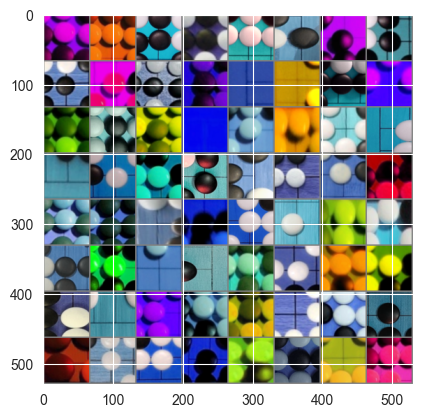

2 2 1 1 2 1 1 1 1 2 1 1 0 0 1 0 1 1 1 0 2 2 0 0 0 2 2 1 0 2 2 1 2 1 0 1 2 2 2 2 1 2 0 0 2 2 2 2 2 0 2 2 1 0 2 1 1 2 2 1 2 1 0 2


In [71]:
def show(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, label_tuples = next(dataiter)

# show images
show(torchvision.utils.make_grid(images))
print(" ".join(f"{label_tuples[j]}" for j in range(BATCH_SIZE)))

### Neural Network

In [72]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

### Optimizer

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [63]:
total_batches = len(train_labels) // BATCH_SIZE
mini_batches = total_batches // 10
total_batches, mini_batches

(303, 30)

In [64]:
for epoch in range(EPOCHS):
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, label_tuples = data

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, label_tuples)
        running_loss += loss
        loss.backward()
        optimizer.step()

        # running_loss += loss.item()
        if i % mini_batches == 0:
            print(
                f"EPOCH: {epoch + 1}, PERCENTAGE: {i / total_batches:.2f} RUNNING LOSS: {running_loss:.4f}"
            )
            running_loss = 0
print("Finished Training")

EPOCH: 1, PERCENTAGE: 0.00 RUNNING LOSS: 1.0883
EPOCH: 1, PERCENTAGE: 0.10 RUNNING LOSS: 18.8597
EPOCH: 1, PERCENTAGE: 0.20 RUNNING LOSS: 8.8350
EPOCH: 1, PERCENTAGE: 0.30 RUNNING LOSS: 7.8602
EPOCH: 1, PERCENTAGE: 0.40 RUNNING LOSS: 6.7753
EPOCH: 1, PERCENTAGE: 0.50 RUNNING LOSS: 5.8595
EPOCH: 1, PERCENTAGE: 0.59 RUNNING LOSS: 6.5615
EPOCH: 1, PERCENTAGE: 0.69 RUNNING LOSS: 4.9488
EPOCH: 1, PERCENTAGE: 0.79 RUNNING LOSS: 5.6281
EPOCH: 1, PERCENTAGE: 0.89 RUNNING LOSS: 4.2957
EPOCH: 1, PERCENTAGE: 0.99 RUNNING LOSS: 3.8592
EPOCH: 2, PERCENTAGE: 0.00 RUNNING LOSS: 0.1576
EPOCH: 2, PERCENTAGE: 0.10 RUNNING LOSS: 3.7812
EPOCH: 2, PERCENTAGE: 0.20 RUNNING LOSS: 3.4732
EPOCH: 2, PERCENTAGE: 0.30 RUNNING LOSS: 3.7744
EPOCH: 2, PERCENTAGE: 0.40 RUNNING LOSS: 3.5112
EPOCH: 2, PERCENTAGE: 0.50 RUNNING LOSS: 2.7113
EPOCH: 2, PERCENTAGE: 0.59 RUNNING LOSS: 3.2092
EPOCH: 2, PERCENTAGE: 0.69 RUNNING LOSS: 3.0595
EPOCH: 2, PERCENTAGE: 0.79 RUNNING LOSS: 2.3218
EPOCH: 2, PERCENTAGE: 0.89 RUNNING LOSS

### Save NN

In [65]:
PATH = "../weights/colored_classification_weights.pth"
torch.save(net.state_dict(), PATH)

In [66]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [67]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, label_tuples = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label_tuples.size(0)
        correct += (predicted == label_tuples).sum().item()
print(
    f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f} %"
)


Accuracy of the network on the 4800 test images: 98.77 %


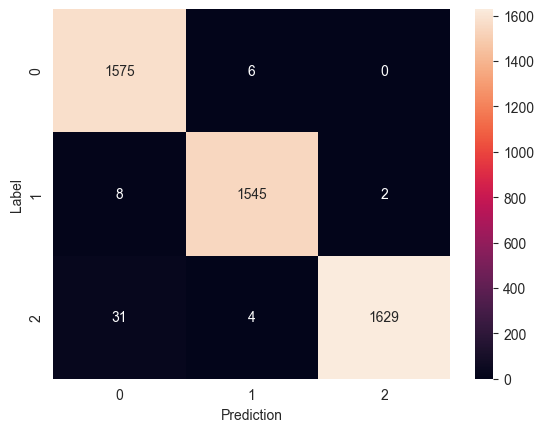

In [68]:
results = []
wrong_images = []

with torch.no_grad():
    for data in test_loader:
        images, label_tuples = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction, image in zip(label_tuples, predictions, images):
            results += [(int(label), int(prediction))]
            if prediction != label:
                wrong_images.append(image)

df = pd.DataFrame(results, columns=["Label", "Prediction"])

heatmap_data = df.pivot_table(
    index="Label", columns="Prediction", aggfunc="size", fill_value=0
)
sns.heatmap(heatmap_data, annot=True, fmt="d")
plt.show()

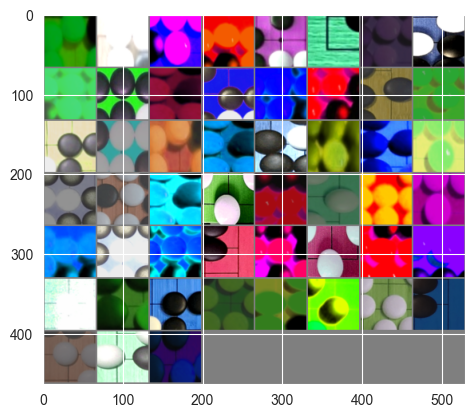

In [69]:
show(torchvision.utils.make_grid(wrong_images))